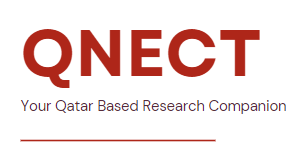

# **Problem**

---



The QRDI Portal, while a valuable resource for researchers in Qatar, presents several challenges:
Information overload: The platform contains a vast amount of information, making it difficult for researchers to quickly find what they are looking for.
Difficult navigation: The user interface is not intuitive, and users need prior knowledge of the information architecture to navigate efficiently.
Lack of personalization: The platform does not provide personalized recommendations for resources, tools, or collaborators.
Limited collaboration support: The platform does not offer functionalities to facilitate collaboration among researchers.
These limitations hinder research productivity and collaboration within the Qatari research ecosystem.
# **Solution**

---
To address these challenges, we propose "Qnect," a chatbot powered by ChatGPT. Qnect aims to simplify research workflows and facilitate collaboration within Qatar's research community.
Features:
Natural Language Processing: Qnect leverages the capabilities of ChatGPT to understand users' research interests and inquiries.
Personalized Recommendations: Based on user input, Qnect recommends relevant research projects, datasets, intellectual property, publications, equipment, services, tools, and experts to collaborate with.
Navigation Assistance: Qnect assists users in navigating the QRDI Portal by directing them to relevant information and resources.
Collaboration Facilitation: Qnect facilitates communication and collaboration between researchers by connecting them with relevant experts and resources.
# **Benefits:**

---

Enhanced Research Efficiency: Qnect reduces the time researchers spend searching for information, allowing them to focus on their research work.
Improved Research Outcomes: Qnect enables researchers to identify valuable resources and collaborators, ultimately leading to better research outcomes.
Increased Collaboration: Qnect fosters collaboration among researchers by connecting them with suitable partners, leading to more impactful research projects.
Simplified User Experience: Qnect provides a user-friendly interface for interacting with the QRDI Portal, making it accessible to researchers with different levels of technical expertise.
Qnect has the potential to significantly enhance the research experience for users of the QRDI Portal, ultimately contributing to the advancement of research and innovation in Qatar.

# **1. Install Dependencies**

In [ ]:
'''
This code installs the required Python packages using the `%pip` magic command.
It installs specific versions of the `langchain`, `openai`, `pypdf`, `chromadb`, `pysqlite3-binary`, and `tiktoken` libraries.
'''
%pip install langchain==0.0.345 openai==1.2.3 pypdf chromadb pysqlite3-binary tiktoken

__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')

# **2. Set API access**

In [ ]:
'''
This code sets environment variables for API access to Azure OpenAI.
It includes the endpoint URL and API keys for both Azure OpenAI and generic OpenAI.
'''
%env AZURE_OPENAI_ENDPOINT=https://<your-endpoint>.openai.azure.com/
%env AZURE_OPENAI_API_KEY=<YOUR_AZUREOPENAI_KEY>
%env OPENAI_API_TYPE=azure
%env OPENAI_API_KEY=<YOUR_AZUREOPENAI_KEY>
%env OPENAI_API_VERSION=2023-05-15

# **3. Load data**
Data Type: URL; json

In [ ]:
'''
This section loads data from a URL using the `WebBaseLoader`.
 The data is then converted into a list of `Document` objects.
'''
from langchain_core.documents.base import Document
from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
import json

url = "https://connect.qrdi.org.qa/api/resourceproject/?page=1&limit=48&typeId=4"
print("Loading data from URL:", url)

#Create a WebBaseLoader object data for loading data from the specified URL
loader = WebBaseLoader("https://connect.qrdi.org.qa/api/resourceproject/?page=1&limit=48&typeId=4")

#loading the documents using the loader
docs = loader.load()

#parse the content of the first document as JSON and extract relevant data
data = json.loads(docs[0].page_content)

#creating the document objects for each item in the extracted data
docs = [Document(page_content=json.dumps(item, indent=2)) for item in data['items']]

""" Another Loading and Splitting Options """
#text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
#docs = loader.load_and_split(text_splitter)

""" Checking """
#len(docs)
len(docs[0].page_content)
print(docs[0].page_content[:500])
#data = json.loads(docs[0].page_content)
#print(data['items'])


# **Other Data Types (optional)**

### PDF loader

In [ ]:
'''
This section loads data from a PDF file using the `PyPDFLoader` and splits it into documents.
'''
'''from langchain.document_loaders import PyPDFLoader

# Load the text of the Geneva Convention.
loader = PyPDFLoader("https://ihl-databases.icrc.org/assets/treaties/365-GC-I-EN.pdf")
docs = loader.load_and_split()
'''

### CSV loader

In [ ]:
'''
This code mounts Google Drive and loads data from a CSV file using the `CSVLoader`.
'''
'''
from google.colab import drive
drive.mount('/content/drive')
'''

In [ ]:
'''
from langchain.document_loaders.csv_loader import CSVLoader
loader = CSVLoader(file_path="/content/drive/MyDrive/Hypo-08.csv")

docs = loader.load()
docs = loader.load_and_split()
print(docs)
'''

### HTML loader

In [ ]:
'''pip install unstructured'''

In [ ]:
'''
This code installs the `unstructured` library and loads data from an HTML file using `UnstructuredHTMLLoader` with text splitting.
'''
'''
from langchain.document_loaders import UnstructuredHTMLLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter



loader = UnstructuredHTMLLoader("/content/drive/MyDrive/QRDIsample2.html")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)

docs = loader.load_and_split(text_splitter)

'''

# 4. Create vector store **retriever**

In [ ]:
'''
This code creates a vector store retriever using the `Chroma` vector store with Azure OpenAI embeddings.
'''
from langchain.vectorstores import Chroma
from langchain.embeddings import AzureOpenAIEmbeddings
from chromadb.config import Settings

#specify the deployment name for Azure OpenAI embeddings
deployment_name = "text-embedding-04"

# creating AzureOpenAIEmbeddings and Chroma vectorstore
embeddings = AzureOpenAIEmbeddings(azure_deployment=deployment_name)
vectorstore = Chroma.from_documents(
    documents=docs,
    embedding=embeddings,
    client_settings=Settings()
)

# assigning vectorstore to retriever
retriever = vectorstore.as_retriever()

# Checking
print(docs[0].page_content[:500])

# **5. Create model**

In [ ]:
'''
This code creates a language model for chat using Azure OpenAI with a specified temperature and deployment name.
'''
from langchain.chat_models import AzureChatOpenAI

temperature = 0.2
deployment_name = "gpt-model-04"
llm = AzureChatOpenAI(temperature=temperature, azure_deployment=deployment_name)

# **6. Perform Q&A**

In [ ]:
'''
This code sets up a question and answer pipeline using a prompt template, retriever, language model, and output parser.
The last line invokes the Q&A process with a specific question.
'''
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema import StrOutputParser

def format_docs(docs):
    print(docs)
    return "\n\n".join(doc.page_content for doc in docs)[:3700]

# creating a prompt template for Question and Answer with specific context/question placeholders
prompt_template = PromptTemplate.from_template("information on QRDI:{context} \n\n question:{question}")

# creating a chain of operations for Q&A using PromptTemplate, language model, and output parsing
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt_template
    | llm
    | StrOutputParser()
)

# Testing (invoke) with a specific question
question = "can you recommend projects related on AR\VR?"
rag_chain.invoke(question)

# **GUI Part**

In [ ]:
# installing dependencies
!pip install gradio

In [ ]:
import gradio as gr
import os
import dotenv

dotenv.load_dotenv()

In [ ]:
# defining a function that takes in the prompt as a question
# allowing to store history
def produce_response(question, history):
    """
      question: user input, normally it is a question asked
      history: chat history
    """
    return rag_chain.invoke(question)

In [ ]:
# creating the chatbot UI within Jupyter using Gradio's ChatInterface
# customizing GUI chatbot
demo = gr.ChatInterface(
  produce_response,
  title="Qnect Chatbot ",
  description="A chatbot for connecting research professionals and fostering collaboration.",
  theme=gr.themes.Soft(primary_hue="red", secondary_hue="indigo"),
  submit_btn="Chat with me!",
  chatbot= gr.Chatbot(label="Qnect", show_label=True, show_copy_button=True)

  )

# launching demo within Jupyter
if __name__ == "__main__":
    demo.launch()